## [Link to all chapters](https://www.kaggle.com/ustcer1984/statistics-with-python-for-data-science)

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

import warnings
warnings.filterwarnings('ignore')

input_path = './data/'
lung = pd.read_csv(input_path + 'LungDisease.csv')
house = pd.read_csv(input_path + 'house_sales.csv', delimiter='\t')

# 4 Regression and Prediction

## 4.1 Simple Linear Regression

#### <center>Key Terms for Simple Linear Regression</center>
- ***Response***  
The variable we are trying to predict.<br>  
*Synonyms*
    - dependent variable, $Y$ variable, target, outcome
- ***Independent variable***  
The variable used to predict the response.<br>  
*Synonyms*
    - $X$ variable, feature, attribute, predictor
- ***Record***  
The vector of predictor and outcome values for a specific individual or case.<br>  
*Synonyms*
    - row, case, instance, example
- ***Intercept***  
The intercept of the regression line—that is, the predicted value when $X = 0$.<br>  
*Synonyms*
    - $b_0$, $β_0$
- ***Regression coefficient***  
The slope of the regression line.<br>  
*Synonyms*
    - slope, $b_1$, $β_1$, parameter estimates, weights
- ***Fitted values***  
The estimates $\hat{Y}_i$ obtained from the regression line.<br>  
*Synonym*
    - predicted values
- ***Residuals***  
The difference between the observed values and the fitted values.<br>  
*Synonym*
    - errors
- ***Least squares***  
The method of fitting a regression by minimizing the sum of squared residuals.<br>  
*Synonyms*
    - ordinary least squares, OLS

### The Regression Equation

$$Y = b_0 + b_1 X$$

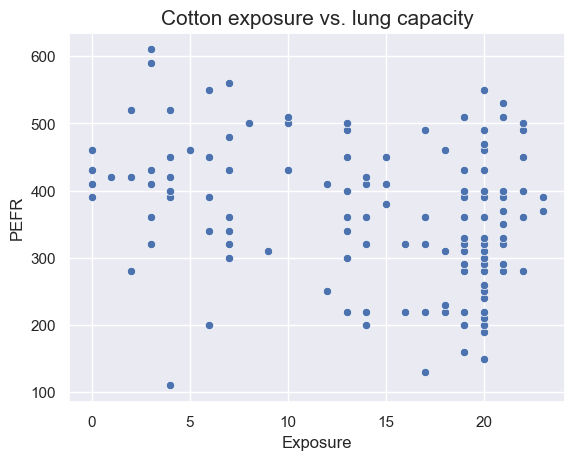

In [2]:
sns.scatterplot(lung, x='Exposure', y='PEFR')
plt.title('Cotton exposure vs. lung capacity', fontsize=15)
plt.show()

Above plot shows the number of years a worker was exposed to cotton dust (Exposure) versus a measure of lung capacity (PEFR or “peak expiratory flow rate”). How is PEFR related to Exposure? We can fit a simple linear regression like below:
$$\text{PEFR} = b_0 + b_1 \text{Exposure}$$

In [3]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583

Coefficient Exposure: -4.185


The intercept, or $b_0$, is 424.583 and can be interpreted as the predicted PEFR for a worker with zero years exposure. The regression coefficient, or $b_1$, can be interpreted as follows: for each additional year that a worker is exposed to cotton dust, the worker’s PEFR measurement is reduced by –4.185.

### Fitted Values and Residuals

The actual data don't fall exactly on a line, so the regression equation should include an explicit error term $e_i$ (*residuals*):
$$Y_i = b_0 + b_1 X_i + e_i$$

The fitted values, also referred to as the *predicted values*, are typically denoted by $\hat{Y_i}$:
$$\hat{Y_i} = \hat{b_0} + \hat{b_1} X_i$$

The notation $\hat{b_0}$ and $\hat{b_1}$ indicates that the coefficients are estimated versus known.

We compute the residuals $e_i$ by subtracting the *predicted* values from the original data:
$$\hat{e_i} = Y_i - \hat{Y_i}$$

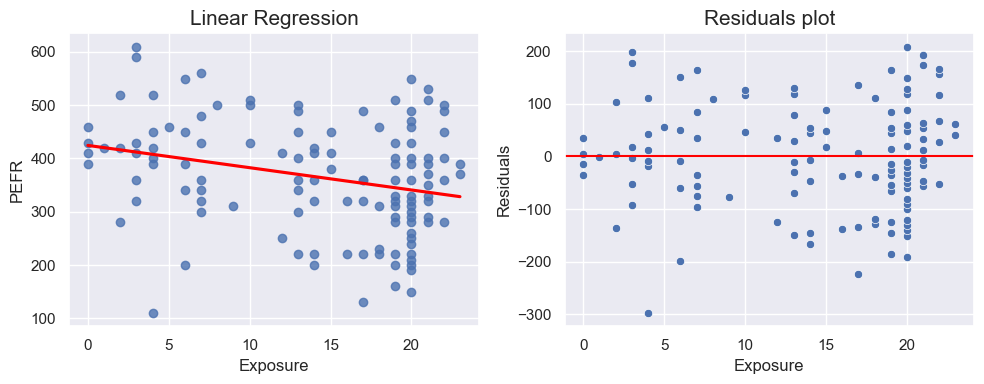

In [4]:
y_predict = model.predict(lung[predictors])
residuals = lung[outcome] - y_predict

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
sns.regplot(lung, x='Exposure', y='PEFR', ci=None, ax=axs[0],
            line_kws={'color': 'red'})
axs[0].set_title('Linear Regression', fontsize=15)
sns.scatterplot(lung, x='Exposure', y=residuals, ax=axs[1])
axs[1].axhline(0, color='red')
axs[1].set_title('Residuals plot', fontsize=15)
axs[1].set_ylabel('Residuals')
fig.tight_layout()
plt.show()

### Least Squares

The regression line is the estimate that minimizes the sum of squared residual values, also called the *residual sum of squares* or RSS:
$$\begin{aligned}
RSS & =  \sum_{i=1}^{n} \left( Y_i - \hat{Y_i} \right)^2 \\
& =  \sum_{i=1}^{n} \left( Y_i - \hat{b_0} - \hat{b_1} X_i \right)^2
\end{aligned}$$

The estimates $\hat{b_0}$ and $\hat{b_1}$ are the values that minimize RSS.

The method of minimizing the sum of the squared residuals is termed *least squares* regression, or *ordinary least squares* (OLS) regression.

**NOTE**:  
- OLS regression is sensitive to outliers.
- The validity of OLS regression comes from the assumption that error lies only within Y (target), not X (predictors).
    - When this assumption is not satified, *total least squares* (TLS) instead of OLS provides better estimations on the coefficients.
    - Here is a good example: --> [Link](https://www.kaggle.com/code/ustcer1984/common-mistakes-in-measurement-machine-correlation)

## 4.2 Multiple Linear Regression

$$Y = b_0 + b_1 X_1 + b_2 X_2 + \cdots + b_p X_p + e$$

#### <center>Key Terms for Multiple Linear Regression</center>
- ***Root mean squared error***  
The square root of the average squared error of the regression (this is the most widely used metric to compare regression models).<br>  
*Synonym*
    - RMSE
- ***Residual standard error***  
The same as the root mean squared error, but adjusted for degrees of freedom.<br>  
*Synonym*
    - RSE
- ***R-squared***  
The proportion of variance explained by the model, from 0 to 1.<br>  
*Synonyms*
    - coefficient of determination, R2
- ***t-statistic***  
The coefficient for a predictor, divided by the standard error of the coefficient, giving a metric to compare the importance of variables in the model.
- ***Weighted regression***  
Regression with the records having different weights.

### Example: King County Housing Data

In [5]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms',
          'Bedrooms', 'BldgGrade']
house[subset].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,300805.0,2400,9373,3.00,6,7
2,1076162.0,3764,20156,3.75,4,10
3,761805.0,2060,26036,1.75,4,8
4,442065.0,3200,8618,3.75,5,7
5,297065.0,1720,8620,1.75,4,7


The goal is to predict the sales price from the other variables.

In [6]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368

Coefficients:

 SqFtTotLiving: 228.8306036024078

 SqFtLot: -0.06046682065306541

 Bathrooms: -19442.840398321016

 Bedrooms: -47769.95518521441

 BldgGrade: 106106.9630789808


### Assessing the Model

**Metric**: *root mean squared error* (RMSE)
$$RMSE = \sqrt{\frac{\sum_{i=1}^{n}\left( y_i - \hat{y_i} \right)^2}{n}}$$

**Metric**: *residual standard error* (RSE)
$$RSE = \sqrt{\frac{\sum_{i=1}^{n}\left( y_i - \hat{y_i} \right)^2}{(n-p-1)}}$$

where $p$ is the number of predictors.

RSE is similar to RMSE with DOF adjustment. In practice, their difference is very small, particularly for big data.

**Metric**: *coefficient of determination*, also called the *R-squared* statistic or $R^2$
$$R^2 = 1 - \frac{\sum_{i=1}^{n}\left( y_i-\hat{y_i} \right)^2}{\sum_{i=1}^{n}\left( y_i-\bar{y} \right)^2}$$

R-squared ranges from 0 to 1 and measures the proportion of variation in the data that is accounted for in the model. It is useful mainly in explanatory uses of regression where you want to assess how well the model fits the data.

**Metric**: adjusted $R^2$
$$R_{adj}^2 = 1 - \left( 1-R^2 \right)\frac{n-1}{n-p-1}$$

where $n$ is the number or records and $p$ is the number of variables in the model. It is similar to $R^2$ with adjustment on DOF.

In [7]:
fitted = house_lm.predict(house[predictors])
RMSE = root_mean_squared_error(house[outcome], fitted)
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220

r2: 0.5406


We can also use `statsmodels` to get a more detailed analysis of the regression model:

In [8]:
model = sm.OLS(
    house[outcome],
    house[predictors].assign(const=1) 
    # add a constant column with value 1 to the predictors
    # this is required by the model to fit intercept
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:51:45   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694      0.000     221.189     236.472
SqFtLot          -0.0605      0.061     -0.988      0.323      -0.180       0.059
Bathrooms     -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
Bedrooms      -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
BldgGrade      1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const         -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This report includes standard error (SE), t-statistic and p-value for each coefficient:
$$t_b = \frac{\hat{b}}{\text{SE}\left( \hat{b} \right)}$$

The higher the t-statistic (and the lower the p-value), the more significant the predictor. It is a useful tool to guide choice of variables to include as predictors.

### Cross-Validation

In above analysis all the metrics are applied "in-sample" (same data used to fit the model). Usually we need to set aside some of the original data, not use it to fit the model, and then apply the model to the set-aside (holdout) data to see how well it does. Normally, you would use a majority of the data to fit the model and use a smaller portion to test the model.

Cross-validation extends the idea of a holdout sample to multiple sequential holdout samples. The algorithm for basic k-fold cross-validation is as follows:  
1. Set aside 1/k of the data as a holdout sample.
2. Train the model on the remaining data.
3. Apply (score) the model to the 1/k holdout, and record needed model assessment metrics.
4. Restore the first 1/k of the data, and set aside the next 1/k (excluding any records that got picked the first time).
5. Repeat steps 2 and 3.
6. Repeat until each record has been used in the holdout portion.
7. Average or otherwise combine the model assessment metrics.

The division of the data into the training sample and the holdout sample is also called a fold.

### Model Selection and Stepwise Regression

In some problems, many variables could be used as predictors in a regression. Adding more variables, however, does not necessarily mean we have a better model. Statisticians use the principle of *Occam’s razor* to guide the choice of a model: all things being equal, a simpler model should be used in preference to a more complicated model.

**Metrics penalize number of variables**  
- adjusted $R^2$
- AIC (Akaike's Information Criteria)
    - $AIC = 2p + n \log(RSS/n)$  
    where $p$ is the number of variables and $n$ is the number of records.
- BIC (Bayesian Information Criteria)
    - Similar to AIC, with a stronger penalty for including additional variables to the model.

How to find the model that minimizes AIC or maximizes adjusted $R^2$?  
- Search through all possible models, an approach called *all subset regression*.
    - Computationally expensive and not feasible for problems with large data and many variables.
- *Stepwise regression*
    - It could start with a full model and successively drop variables that don't contribute meaningfully. This is called *backward elimination*.
    - Alternatively one could start with a constant model and successively add variables (*forward selection*).
- *Penalized regression*
    - Rather than eliminating predictor variables entirely, penalized regression applies the penalty by reducing coefficients, in some cases to near zero.
    - Common penalized regression methods are *ridge regression* and *lasso regression*.

### Weighted Regression

Data scientists may find weighted regression useful in two cases:  
- Inverse-variance weighting when different observations have been measured with different precision; the higher variance ones receiving lower weights.
- Analysis of data where rows represent multiple cases; the weight variable encodes how many original observations each row represents.

For example, with the housing data, older sales are less reliable than more recent sales. Using the DocumentDate to determine the year of the sale, we can compute a Weight as the number of years since 2005 (the beginning of the data):

In [9]:
# calculate weight
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Weight'] = house.Year - 2005

# fit linear model with weight
house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome],
             sample_weight=house['Weight'])

# compare coefficients
lm_coefficients = pd.Series(
    [house_lm.intercept_] + house_lm.coef_.tolist(),
    index = ['(Intercept)'] + predictors,
    name = 'house_lm'
)
wt_coefficients = pd.Series(
    [house_wt.intercept_] + house_wt.coef_.tolist(),
    index = ['(Intercept)'] + predictors,
    name = 'house_wt'
)
pd.concat([lm_coefficients, wt_coefficients], axis=1)

,house_lm,house_wt
(Intercept),-521871.368188,-584189.329446
SqFtTotLiving,228.830604,245.024089
SqFtLot,-0.060467,-0.292415
Bathrooms,-19442.840398,-26085.970109
Bedrooms,-47769.955185,-53608.876436
BldgGrade,106106.963079,115242.434726


The coefficients in the weighted regression are slightly different from the original regression.

## 4.3 Prediction Using Regression

#### <center>Key Terms for Prediction Using Regression</center>
- ***Prediction interval***  
An uncertainty interval around an individual predicted value.
- ***Extrapolation***  
Extension of a model beyond the range of the data used to fit it.

### The Dangers of Extrapolation

Regression models should not be used to extrapolate beyond the range of the data (leaving aside the use of regression for time series forecasting.).

### Confidence and Prediction Intervals

A bootstrap algorithm for generating confidence intervals for regression parameters (coefficients) for a data set with P predictors and n records (rows):  
1. Consider each row (including outcome variable) as a single “ticket” and place all the $n$ tickets in a box.
2. Draw a ticket at random, record the values, and replace it in the box.
3. Repeat step 2 $n$ times; you now have one bootstrap resample.
4. Fit a regression to the bootstrap sample, and record the estimated coefficients.
5. Repeat steps 2 through 4, say, 1,000 times.
6. You now have 1,000 bootstrap values for each coefficient; find the appropriate percentiles for each one (e.g., 5th and 95th for a 90% confidence interval).

The bootstrap algorithm for modeling both the regression model error and the individual data point error would look as follows:  
1. Take a bootstrap sample from the data (spelled out in greater detail earlier).
2. Fit the regression, and predict the new value.
3. Take a single residual at random from the original regression fit, add it to the predicted value, and record the result.
4. Repeat steps 1 through 3, say, 1,000 times.
5. Find the 2.5th and the 97.5th percentiles of the results.

## 4.4 Factor Variables in Regression

*Factor* variables, also termed *categorical* variables, take on a limited number of discrete values.

#### <center>Key Terms for Factor Variables</center>
- ***Dummy variables***  
Binary 0–1 variables derived by recoding factor data for use in regression and other models.
- ***Reference coding***  
The most common type of coding used by statisticians, in which one level of a factor is used as a reference and other factors are compared to that level.<br>  
*Synonym*
    - treatment coding
- ***One hot encoder***  
A common type of coding used in the machine learning community in which all factor levels are retained.
- ***Deviation coding***  
A type of coding that compares each level against the overall mean as opposed to the reference level.<br>  
*Synonym*
    - sum contrasts

### Dummy Variables Representation

In [10]:
house['PropertyType'].unique()

array(['Multiplex', 'Single Family', 'Townhouse'], dtype=object)

This is a factor variable with 3 categories. We can dummy encoded (also called one hot encoded) it:

In [11]:
pd.get_dummies(house['PropertyType']).head()

,Multiplex,Single Family,Townhouse
1,True,False,False
2,False,True,False
3,False,True,False
4,False,True,False
5,False,True,False


For multiple linear regression, we need to drop 1 column to avoid multicollinearity error:

In [12]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366

Coefficients:

 SqFtTotLiving: 223.37362892503808

 SqFtLot: -0.07036798136811129

 Bathrooms: -15979.01347341519

 Bedrooms: -50889.73218483009

 BldgGrade: 109416.30516146167

 PropertyType_Single Family: -84678.21629549259

 PropertyType_Townhouse: -115121.97921609192


### Factor Variables with Many Levels

In [13]:
house['ZipCode'].value_counts()

ZipCode
98038    788
98103    671
98042    641
98115    620
98117    619
        ... 
98288      4
98224      3
98068      1
98113      1
98043      1
Name: count, Length: 80, dtype: int64

This variable has 80 categories and some contains very few records. `ZipCode` is an important variable to predict house pricing, but simply dummy encoding it is not a good idea.

An alternative approach is to group the zip codes according to another variable, such as sale price. Even better is to form zip code groups using the residuals from an initial model.

In [14]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']

zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual': house[outcome] - house_lm.predict(house[predictors])
    })
    .groupby('ZipCode')
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False,
                                 retbins=False)

to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

house[[*predictors] + ['ZipGroup']].head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,ZipGroup
1,2400,9373,3.00,6,7,2
2,3764,20156,3.75,4,10,2
3,2060,26036,1.75,4,8,2
4,3200,8618,3.75,5,7,2
5,1720,8620,1.75,4,7,2


### Ordered Factor Variables

Some factor variables reflect levels of a factor, `BldgGrade` is an example.

*Building grades and numeric equivalents*
| **Value** | **Description** |
|:---------:|-----------------|
|     1     | Cabin           |
|     2     | Substandard     |
|     5     | Fair            |
|     10    | Very good       |
|     12    | Luxury          |
|     13    | Mansion         |

Treating ordered factors as a numeric variable preserves the information contained in the ordering that would be lost if it were dummy encoded.

## 4.5 Interpreting the Regression Equation

#### <center>Key Terms for Interpreting the Regression Equation</center>
- ***Correlated variables***  
When the predictor variables are highly correlated, it is difficult to interpret the individual coefficients.
- ***Multicollinearity***  
When the predictor variables have perfect, or near-perfect, correlation, the regression can be unstable or impossible to compute.<br>  
*Synonym*
    - collinearity
- ***Confounding variables***  
An important predictor that, when omitted, leads to spurious relationships in a regression equation.
- ***Main effects***  
The relationship between a predictor and the outcome variable, independent of other variables.
- ***Interactions***  
An interdependent relationship between two or more predictors and the response.

### Correlated Predictors

In [15]:
print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368

Coefficients:

 SqFtTotLiving: 228.8306036024078

 SqFtLot: -0.06046682065306541

 Bathrooms: -19442.840398321016

 Bedrooms: -47769.95518521441

 BldgGrade: 106106.9630789808


The coefficient for Bedrooms is negative! This implies that adding a bedroom to a house will reduce its value. How can this be? This is because the predictor variables are correlated: larger houses tend to have more bedrooms, and it is the size that drives house value, not the number of bedrooms. Consider two homes of the exact same size: it is reasonable to expect that a home with more but smaller bedrooms would be considered less desirable.

### Multicollinearity

Perfect multicollinearity occurs when one predictor variable can be expressed as a linear combination of others. Multicollinearity occurs when:  
- A variable is included multiple times by error.
- *P* dummies, instead of *P* – 1 dummies, are created from a factor variable.
- Two variables are nearly perfectly correlated with one another.

Multicollinearity in regression must be addressed—variables should be removed until the multicollinearity is gone. A regression does not have a well-defined solution in the presence of perfect multicollinearity.

Multicollinearity is not such a problem for nonlinear regression methods like trees, clustering, and nearest-neighbors, and in such methods it may be advisable to retain *P* dummies (instead of *P* – 1). That said, even in those methods, nonredundancy in predictor variables is still a virtue.

### Confounding Variables

In [16]:
print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368

Coefficients:

 SqFtTotLiving: 228.8306036024078

 SqFtLot: -0.06046682065306541

 Bathrooms: -19442.840398321016

 Bedrooms: -47769.95518521441

 BldgGrade: 106106.9630789808


The regression coefficients of `SqFtLot`, `Bathrooms`, and `Bedrooms` are all negative. The original regression model does not contain a (confounding) variable to represent location—a very important predictor of house price.

To model location, we can include the variable `ZipGroup` that categorizes the zip code into one of five groups, from least expensive (1) to most expensive (5):

In [17]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469

Coefficients:

 SqFtTotLiving: 210.61266005580123

 SqFtLot: 0.4549871385465991

 Bathrooms: 5928.425640001543

 Bedrooms: -41682.87184074484

 BldgGrade: 98541.18352725974

 PropertyType_Single Family: 19323.625287918854

 PropertyType_Townhouse: -78198.7209276242

 ZipGroup_1: 53317.17330659845

 ZipGroup_2: 116251.58883563541

 ZipGroup_3: 178360.5317879335

 ZipGroup_4: 338408.6018565198


`ZipGroup` is clearly an important variable: a home in the most expensive zip code group is estimated to have a higher sales price by almost $340,000. The coefficients of SqFtLot and Bathrooms are now positive, and adding a bathroom increases the sale price by $5,928.

The coefficient for Bedrooms is still negative. While this is unintuitive, this is a well known phenomenon in real estate. For homes of the same livable area and number of bathrooms, having more and therefore smaller bedrooms is associated with less valuable homes.

### Interactions and Main Effects

In [18]:
model = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving*ZipGroup + SqFtLot + ' +
                'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:51:46   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -4.853e+05   2.05e+04    -23.701      0.000   -5.25e+05   -4.45e+05
ZipGroup[T.1]                 -1.113e+04   1.34e+04     -0.830      0.407   -3.74e+04    1.52e+04
ZipGroup[T.2]                  2.032e+04   1.18e+04      1.717      0.086   -2877.441    4.35e+04
ZipGroup[T.3]                   2.05e+04   1.21e+04      1.697      0.090   -3180.870    4.42e+04
ZipGroup[T.4]                 -1.499e+05   1.13e+04    -13.285      0.000   -1.72e+05   -1.28e+05
PropertyType[T.Single Family]  1.357e+04   1.39e+04      0.975      0.330   -1.37e+04    4.09e+04
PropertyType[T.Townhouse]     -5.884e+04   1.51e+04     -3.888      0.000   -8.85e+04   -2.92e+04
SqFtTotLiving                   114.7650      4.863     23.600      0.000     105.233     124.297
SqFtTotLiving:ZipGroup[T.1]      32.6043      5.712      5.708      0.000      21.409      43.799
SqFtTotLiving:ZipGroup[T.2]      41.7822      5.187      8.056      0.000      31.616      51.948
SqFtTotLiving:ZipGroup[T.3]      69.3415      5.619     12.341      0.000      58.329      80.354
SqFtTotLiving:ZipGroup[T.4]     226.6836      4.820     47.032      0.000     217.237     236.131
SqFtLot                           0.6869      0.052     13.296      0.000       0.586       0.788
Bathrooms                     -3619.4533   3202.296     -1.130      0.258   -9896.174    2657.267
Bedrooms                       -4.18e+04   2120.279    -19.715      0.000    -4.6e+04   -3.76e+04
BldgGrade                      1.047e+05   2069.472     50.592      0.000    1.01e+05    1.09e+05
==============================================================================
Omnibus:                    30927.394   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34361794.502
Skew:                           7.279   Prob(JB):                         0.00
Kurtosis:                     193.101   Cond. No.                     5.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Location and house size clearly have strong interaction.

## 4.6 Regression Diagnostics

#### <center>Key Terms for Regression Diagnostics</center>
- ***Standardized residuals***  
Residuals divided by the standard error of the residuals.
- ***Outliers***  
Records (or outcome values) that are distant from the rest of the data (or the predicted outcome).
- ***Influential value***  
A value or record whose presence or absence makes a big difference in the regression equation.
- ***Leverage***  
The degree of influence that a single record has on a regression equation.<br>  
*Synonym*
    - hat-value
- ***Non-normal residuals***  
Non-normally distributed residuals can invalidate some technical requirements of regression but are usually not a concern in data science.
- ***Heteroskedasticity***  
When some ranges of the outcome experience residuals with higher variance (may indicate a predictor missing from the equation).
- ***Partial residual plots***  
A diagnostic plot to illuminate the relationship between the outcome variable and a single predictor.<br>  
*Synonym*
    - added variables plot

### Outliers

In regression, the standardized residual is the metric that is typically used to determine whether a record is classified as an outlier.

Let’s fit a regression to the King County house sales data for all sales in zip code 98105.

In [19]:
house_98105 = house[house['ZipCode'] == 98105]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(
    house_98105[outcome],
    house_98105[predictors].assign(const=1)
)
result_98105 = house_outlier.fit()

influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(24333, -4.326731804078564)

The biggest overestimate from the model is more than four standard errors above the regression line, corresponding to an overestimate of $757,754. There is obviuosly something wrong with this record.

### Influential Values

A value whose absence would significantly change the regression equation is termed an *influential observation*.

**Metrics**  
- *hat value*
    - values above 2(*P* + 1)/*n* indicate a high leverage data value.
- *Cook's distance*
    - values exceed 4/(*n* - *P* - 1) indicate a high leverage data value.

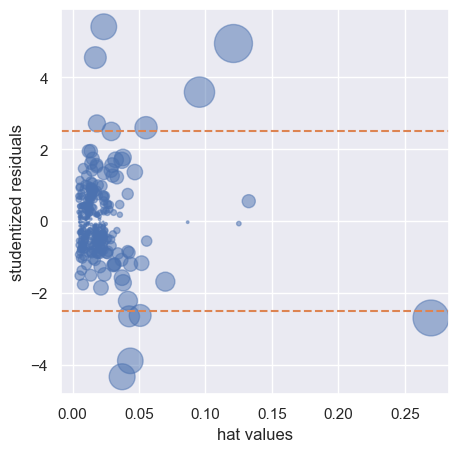

In [20]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)
ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')
plt.show()

### Heteroskedasticity, Non-Normality, and Correlated Errors

*Heteroskedasticity* is the lack of constant residual variance across the range of the predicted values. In other words, errors are greater for some portions of the range than for others. Visualizing the data is a convenient way to analyze residuals.

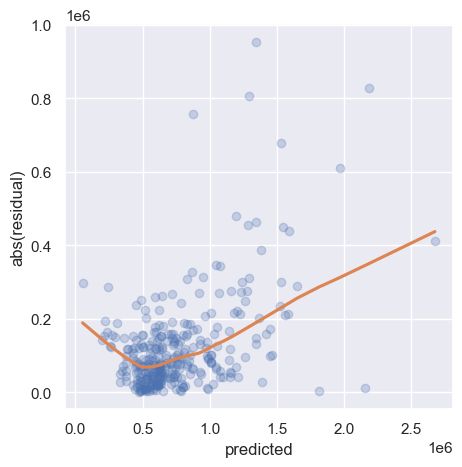

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid),
            scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')
plt.show()

Evidently, the variance of the residuals tends to increase for higher-valued homes but is also large for lower-valued homes. This plot indicates that lm_98105 has *heteroskedastic* errors.

Heteroskedasticity indicates that prediction errors differ for different ranges of the predicted value, and may suggest an incomplete model. For example, the heteroskedasticity in lm_98105 may indicate that the regression has left something unaccounted for in highand low-range homes.

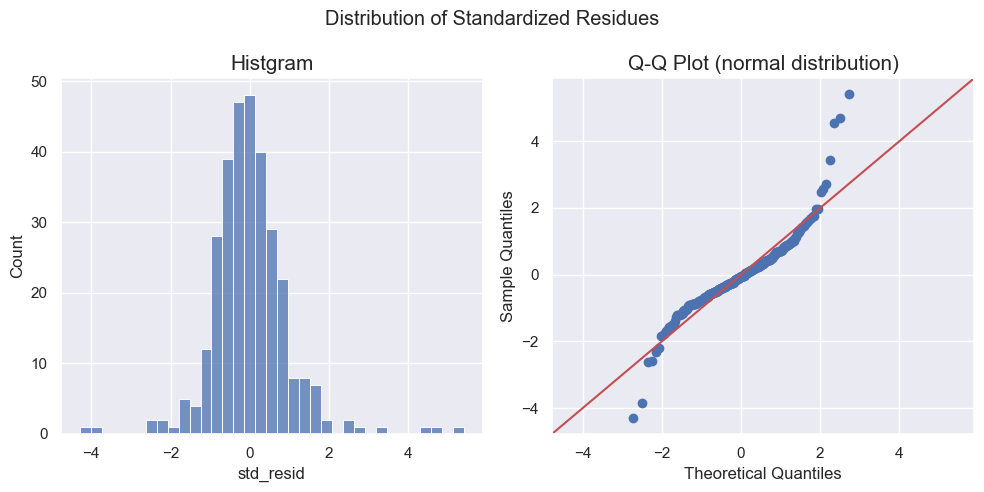

In [22]:
std_resid = StandardScaler().fit_transform(result_98105.resid.to_frame()).reshape(-1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x=std_resid, ax=axs[0])
sm.qqplot(std_resid, line='45', ax=axs[1])
axs[0].set_xlabel('std_resid')
fig.suptitle('Distribution of Standardized Residues')
axs[0].set_title('Histgram', fontsize=15)
axs[1].set_title('Q-Q Plot (normal distribution)', fontsize=15)
fig.tight_layout()
plt.show()

Above plot shows the distribution of the standardized residuals for the lm_98105 regression. The distribution has decidedly longer tails than the normal distribution and exhibits mild skewness toward larger residuals.

### Partial Residual Plots and Nonlinearity

A partial residual for predictor $X_i$ is the ordinary residual plus the regression term associated with $X_i$:
$$\text{Partial residual} = \text{Residual} + \hat{b_i} X_i$$
where $\hat{b_i}$ is the estimated regression coefficient.

*Partial residual plots* are a way to visualize how well the estimated fit explains the relationship between a predictor and the outcome. The basic idea of a partial residual plot is to isolate the relationship between a predictor variable and the response, *taking into account all of the other predictor variables*.

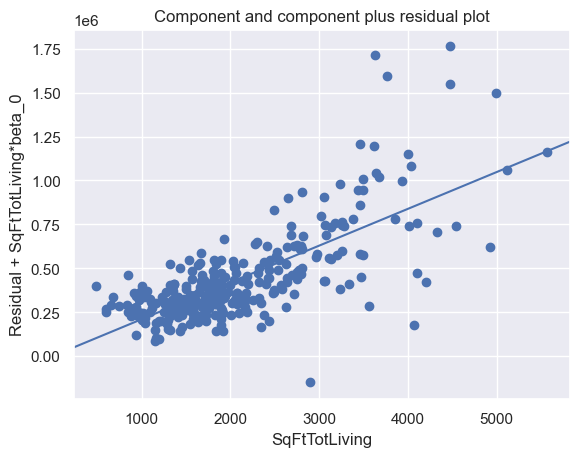

In [23]:
sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving')
plt.show()

The regression line (solid line) underestimates the sales price for homes less than 1,000 square feet and overestimates the price for homes between 2,000 and 3,000 square feet. It suggests that instead of a simple linear term for `SqFtTotLiving`, a nonlinear term should be considered.

## 4.7 Polynomial and Spline Regression

#### <center>Key Terms for Nonlinear Regression</center>
- ***Polynomial regression***  
Adds polynomial terms (squares, cubes, etc.) to a regression.
- ***Spline regression***  
Fitting a smooth curve with a series of polynomial segments.
- ***Knots***  
Values that separate spline segments.
- ***Generalized additive models***  
Spline models with automated selection of knots.<br>  
*Synonym*
    - GAM

### Polynomial

*Polynomial regression* involves including polynomial terms in a regression equation.

In [24]:
model_poly = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving ' +
                     '+ I(SqFtTotLiving**2) + ' +
                     'SqFtLot + Bathrooms + Bedrooms + BldgGrade', 
                     data=house_98105)
result_poly = model_poly.fit()
result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 19 Apr 2024   Prob (F-statistic):          9.95e-106
Time:                        00:51:49   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -6.159e+05   1.03e+05     -5.953      0.000   -8.19e+05   -4.12e+05
SqFtTotLiving             7.4521     55.418      0.134      0.893    -101.597     116.501
I(SqFtTotLiving ** 2)     0.0388      0.010      4.040      0.000       0.020       0.058
SqFtLot                  32.5594      5.436      5.990      0.000      21.863      43.256
Bathrooms             -1435.1231   1.95e+04     -0.074      0.941   -3.99e+04     3.7e+04
Bedrooms              -9191.9441   1.33e+04     -0.693      0.489   -3.53e+04    1.69e+04
BldgGrade              1.357e+05   1.49e+04      9.087      0.000    1.06e+05    1.65e+05
==============================================================================
Omnibus:                       75.161   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.978
Skew:                           0.699   Prob(JB):                    2.92e-139
Kurtosis:                       9.853   Cond. No.                     7.37e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

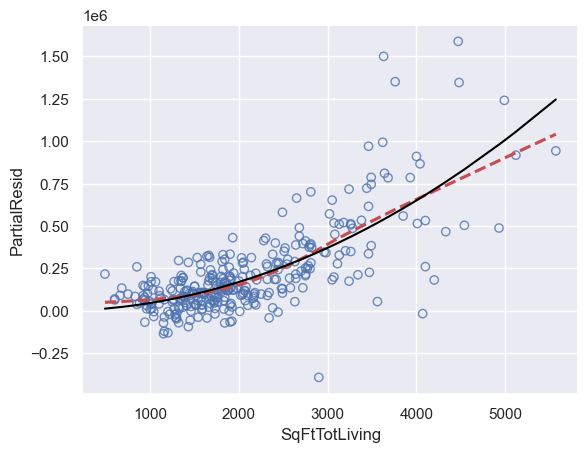

In [25]:
X = house_98105['SqFtTotLiving']
resid = result_poly.resid
b1 = result_poly.params['SqFtTotLiving']
b2 = result_poly.params['I(SqFtTotLiving ** 2)']
partial_resid = (
    resid +
    b1 * X +
    b2 * X * X
)
pred = b1 * X + b2 * X * X

sns.regplot(
    x = X,
    y = partial_resid,
    lowess = True,
    line_kws = {'ls': '--', 'color': 'C3'},
    scatter_kws = {'facecolors': 'none'}
)
sns.lineplot(
    x = X,
    y = pred,
    color = 'black'
)
plt.ylabel('PartialResid')
plt.show()

### Splines

The technical definition of a spline is a series of piecewise continuous polynomials. The polynomial pieces are smoothly
connected at a series of fixed points in a predictor variable, referred to as *knots*.

### Generalized Additive Models

*Generalized additive models*, or *GAM*, are a flexible modeling technique that can be used to automatically fit a spline regression.